# Notebook with poster Results
Must be run using Python 3.5

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import itertools
from collections import defaultdict

import math
import nolds

#XGBoost now needs path to runtime compilers
import os
# mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
# os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper

from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score


path = '../Datasets/Spasticity/LabeledData/'
savepath = '../Datasets/Spasticity/'
sns.set_context('talk',font_scale=1)
sns.despine()

In [2]:
current_palette = sns.color_palette()

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '--'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    return ax

In [3]:
def getFeatures(EMGSignal):
    
    EPS = .0001
    
    Feat = {}
    Feat['MeanAbsValue'] = np.mean(np.abs(EMGSignal))
    
    PosInds = EMGSignal>0
    Feat['ZeroCrossings'] = sum((PosInds[1:len(PosInds)] != PosInds[0:(len(PosInds)-1)]) & (np.abs(np.diff(EMGSignal))>EPS))
    
    DiffEMGSignal = np.diff(EMGSignal)
    PosInds = DiffEMGSignal>0
    Feat['SlopeZeroCrossings'] = sum((PosInds[1:len(PosInds)] != PosInds[0:(len(PosInds)-1)]) & 
                                     (np.abs(np.diff(DiffEMGSignal))>EPS))
    
    Feat['WaveformLength'] = np.mean(np.abs(EMGSignal[1:len(EMGSignal)-1]-EMGSignal[2:len(EMGSignal)]))
    
    Feat['WillisonAmplitude'] = sum(np.abs(EMGSignal[1:len(EMGSignal)-1]-EMGSignal[2:len(EMGSignal)])>EPS)
    
    Feat['RMS'] = math.sqrt(np.mean(np.square(EMGSignal)))
    
    Feat['Variance'] = np.var(EMGSignal)
    
    
    FFTPow = np.square(np.abs(np.fft.rfft(EMGSignal)))
    for i, key in enumerate(['FFT:0-20Hz', 'FFT:20-40Hz', 'FFT:40-60Hz', 'FFT:60-80Hz', 'FFT:80-100Hz', 'FFT:100-120Hz']):
        Feat[key] = np.sum(FFTPow[1+int(len(FFTPow)/6 * i):int(len(FFTPow)/6 * (i+1))])
    # TODO: Sample Entropy and FFT
    
    Feat['SampEn'] = nolds.sampen(EMGSignal)
    Feat['FFT:SampEn'] = nolds.sampen(FFTPow)
    
    return Feat

In [4]:
def getClips(EMGSignal, winsize, overlap):
    Clips = []
    Features = defaultdict(list)
    for indStart in range(0,int(len(EMGSignal)-winsize),int(winsize*(1-overlap))):
        Clip = np.asarray(EMGSignal[indStart:indStart+125])
        Feat = getFeatures(Clip)
        Clips.append(Clip)
        for key in Feat:
            Features[key].append(Feat[key])
        
    return Clips, Features

In [7]:
winsize = 1 * 250 # Test different values later (*250 to convert sec to samples)
overlap = .5 # 0-1; use value such that winsize*overlap is integer for now

RawDataClips = []
Features = defaultdict(list)
ClipLabels = []
SubjID = []
Location = []

for x in itertools.product(range(1,31),['Lab Day1','Lab Day2'],['Gastrocnemius', 'Hamstring'],['MAS', 'MVC', 'VCM']):
    if x[2]=='Hamstring':
        Act = 'KF'
    else:
        Act = 'PF'
    
    oldLen = len(RawDataClips)
    
    try:
        Data = pd.read_csv(path + 'CS' + str(x[0]).zfill(3) + '/' + x[1] + '/' + x[2] + '_' + x[3] + ' ' + Act + '_labeled.csv',
                          header = None)
        if x[2]=='Hamstring':
            Labind = 8
        else:
            Labind = 5
            
        EMGData = Data[4]
        Label = Data[Labind]
        
        for l in zip(['Spastic Activity', 'Non-Spastic Activity', 'Inactive'],['SA','HA','IA']):
            lab_old = l[0]
            lab_new = l[1]
            
            lab_inds = Label==lab_old
            lab_inds_diff = lab_inds[1:len(lab_inds)].values != lab_inds[0:len(lab_inds)-1].values
            
            # Get starts/ends of continuous labels
            print(x)
            cont_label_startend = [i+1 for i,x in enumerate(lab_inds_diff) if x]
            print(x)
            # Note: this assumes that the data stream begins and ends with unlabeled data
            # Even indices are starts, odds are ends
            for nLabel in range(0,len(cont_label_startend),2): 
                LabeledData = EMGData[cont_label_startend[nLabel]:cont_label_startend[nLabel+1]]
                
                newClips, newFeatures = getClips(LabeledData, winsize, overlap)
                
                RawDataClips += newClips
                for key in newFeatures:
                    Features[key] += newFeatures[key]
                print x
                SubjID += [x[0]] * len(newClips)
                ClipLabels += [lab_new]*len(newClips)
                Location += [x[2]]*len(newClips)
            
    except(OSError):
        print(path + 'CS' + str(x[0]).zfill(3) + '/' + x[1] + '/' + x[2] + '_' + x[3] + ' ' + Act + '_labeled.csv')
        

(1, 'Lab Day1', 'Gastrocnemius', 'MAS')
False
False


IndexError: invalid index to scalar variable.

In [56]:
FullData = pd.DataFrame(Features).assign(RawData=pd.Series(RawDataClips), SubjID=pd.Series(SubjID), Label=pd.Series(ClipLabels), Location=pd.Series(Location))

In [103]:
#save Clips Data
FullData.to_csv(path_or_buf=savepath+'Clips_ws'+str(winsize/250)+'_overlap'+str(overlap)+'.csv')

In [8]:
#Load Clips Data
# FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.8.csv')
# FullData = pd.read_csv(savepath+'Clips_ws0.5_overlap0.8.csv')
FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.5.csv')

print (FullData.shape)

(1557, 20)


In [57]:
FullData.head()

,FFT:0-20Hz,FFT:100-120Hz,FFT:20-40Hz,FFT:40-60Hz,FFT:60-80Hz,FFT:80-100Hz,FFT:SampEn,MeanAbsValue,RMS,SampEn,SlopeZeroCrossings,Variance,WaveformLength,WillisonAmplitude,ZeroCrossings,Label,Location,RawData,SubjID
0,1.225662e-05,4.522854e-07,0.000021,0.000019,0.000004,3.042505e-06,0.556572,0.000043,0.000092,0.277610,15,8.436106e-09,0.000043,16,9,SA,Gastrocnemius,"[-1.25376354234e-05, 0.000256419017388, 0.0004...",1
1,6.266326e-06,8.328662e-07,0.000002,0.000006,0.000010,2.119288e-06,0.680244,0.000035,0.000061,0.298195,22,3.759755e-09,0.000041,18,12,SA,Gastrocnemius,"[-1.54166153598e-05, -2.58201167855e-05, -2.52...",1
2,4.509514e-06,1.404923e-06,0.000002,0.000004,0.000004,3.215455e-06,1.634131,0.000029,0.000051,0.364294,17,2.623056e-09,0.000035,11,6,SA,Gastrocnemius,"[1.65414212235e-06, 1.16601537833e-05, 9.49498...",1
3,4.827563e-07,3.273109e-07,0.000002,0.000002,0.000002,4.519934e-07,0.821528,0.000025,0.000031,1.905419,15,9.858629e-10,0.000030,1,1,HA,Gastrocnemius,"[1.23416107599e-05, -1.96147267426e-05, -9.001...",1
4,8.930556e-07,2.265097e-07,0.000002,0.000002,0.000002,7.133348e-07,0.910212,0.000027,0.000032,2.410799,12,1.040651e-09,0.000034,0,0,HA,Gastrocnemius,"[-2.24706359465e-05, 1.10109352551e-05, -2.817...",1


In [58]:
FullData.RawData[0]

array([ -1.25376354e-05,   2.56419017e-04,   4.93338747e-04,
         3.67581616e-04,  -2.29709275e-05,  -4.05165351e-04,
        -3.04702587e-04,  -3.24991016e-05,   1.77747853e-05,
        -6.06080741e-05,  -9.86944257e-05,  -6.94144339e-05,
         1.48036758e-05,   5.09978675e-05,   1.87972303e-05,
         1.69205166e-05,   2.15678819e-05,   2.48073147e-05,
         1.14261645e-05,  -7.03906696e-07,  -8.79860180e-07,
         1.74623428e-06,  -2.92009839e-07,  -2.60239581e-06,
         8.08939505e-07,  -2.33183856e-06,  -4.60215511e-07,
         3.98879731e-06,  -8.42855126e-06,  -4.50573511e-06,
        -9.65539137e-07,  -1.26658962e-05,  -1.27908682e-05,
        -1.25600618e-05,  -7.23294257e-06,  -6.77223503e-06,
        -8.92702602e-06,   5.87283297e-06,   2.20837828e-05,
        -5.34315793e-06,  -2.89079327e-05,  -2.78316594e-05,
        -2.80458440e-05,  -7.93467015e-06,   1.70907648e-05,
         1.69045512e-05,  -8.92629749e-06,  -1.00302099e-05,
        -2.22935410e-05,

In [10]:
[sum(FullData.SubjID[FullData.Location=='Hamstring']==s) for s in FullData.SubjID[FullData.Location=='Hamstring'].unique()]

[13, 73, 38, 78, 100, 16, 17, 136, 81, 40, 15, 120, 28, 28, 3]

In [21]:
print('SA clips = %d'%sum(FullData[FullData.Location=='Hamstring'].Label=='SA'))
print('HA clips = %d'%sum(FullData[FullData.Location=='Hamstring'].Label=='HA'))

SA clips = 117
HA clips = 632


In [16]:
[sum(FullData.SubjID[FullData.Location=='Gastrocnemius']==s) for s in FullData.SubjID[FullData.Location=='Gastrocnemius'].unique()]

[19,
 24,
 60,
 33,
 67,
 71,
 31,
 76,
 47,
 49,
 5,
 67,
 1,
 3,
 13,
 49,
 46,
 23,
 24,
 52,
 11]

In [22]:
print('SA clips = %d'%sum(FullData[FullData.Location=='Gastrocnemius'].Label=='SA'))
print('HA clips = %d'%sum(FullData[FullData.Location=='Gastrocnemius'].Label=='HA'))

SA clips = 32
HA clips = 686


In [108]:
FullData.shape

(1557, 20)

In [109]:
#fit base-level and meta-level classifier 
def fit_stacking(X_train,y_train,groups): 
    
    base_classifiers = [];     meta_classifier = []
    subj = LeaveOneGroupOut()

    Xtrain_meta = np.zeros((len(y_train),len(models))) #stores the meta-level classifier features (posterior of each base-level classifier)
    ytrain_meta = np.array([]) #stores the labels to train meta-classifier
    i = 0 #counter for current classifier trained

    #CV to train base level clf and obtain train features for meta-level
    for clf,name in zip(models,model_name):

        print(name)
        yscoreCV = np.array([])  #stores the posterior prob of each base-level clf

        #CV to obtain posteriors from each clf (meta-features)
        for train, test in subj.split(X_train, y_train, groups):
            clf.fit(X_train[train,:],y_train[train])
            yscore = clf.predict_proba(X_train[test,:]) 
            yscore = yscore[:,1]
            yscoreCV = np.append(yscoreCV,yscore) #concatenate scores for each fold
            if i == 0:
                #store labels to train metaclassifier ()
                ytrain_meta = np.append(ytrain_meta,y_train[test])

        Xtrain_meta[:,i] = yscoreCV #store the posterior of current clf
        i +=1

        #Train base level classifiers on all training data    
        clf.fit(X_train,y_train)
        base_classifiers.append(clf)
        
    print('base-level classifiers trained')
        
    #add extra meta-features 
    metastd = np.std(Xtrain_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtrain_meta = np.concatenate((Xtrain_meta,metastd.T),axis=1)
    
    #train meta-level classifier on posteriors (this needs another CV to optimize parameters)
    meta_scaler = preprocessing.StandardScaler().fit(Xtrain_meta)
    Xtrain_meta = meta_scaler.transform(Xtrain_meta)
    print('training meta-classifier')
    metaclf = LogisticRegression(C=1)
#     metaclf = GradientBoostingClassifier(n_estimators=100,max_depth=2,random_state=3)
    metaclf.fit(np.concatenate((Xtrain_meta,X_train),axis=1),ytrain_meta)
    ypred_meta = metaclf.predict_proba(np.concatenate((Xtrain_meta,X_train),axis=1))
#     ind = np.where(np.array(ypred_meta) != np.array(ytrain_meta))
#     print Xtrain_meta[:10,:]
#     plt.figure(figsize=(12,8))
#     sns.heatmap(Xtrain_meta[ind,:])

    meta_classifier.append(metaclf)

    return base_classifiers, meta_classifier[0], meta_scaler

In [23]:
def predict_stacking(X_test,y_test,base_classifiers,meta_classifier,meta_scaler):
    
    Xtest_meta = np.zeros((len(y_test),len(base_classifiers))) #stores the base clf predictions for current subj
    auc_base = np.empty( (len(models),1) ) #store auc for each base classifier
    i = 0 #clf index

    #1. base-classifiers predictions
    for clf,name in zip(base_classifiers,model_name):
        Xtest_meta[:,i] = clf.predict_proba(X_test)[:,1]
        auc_base[i] = roc_auc_score(y_test, Xtest_meta[:,i])
        i+=1
    print('best base-clf %s, auc = %.3f, worst base-clf %s, minauc = %.3f' % (model_name[np.argmax(auc_base)],
                                                                       np.max(auc_base),
                                                                       model_name[np.argmin(auc_base)],
                                                                       np.min(auc_base)))

    #add extra meta features
    metastd = np.std(Xtest_meta,axis=1)
    metastd = np.expand_dims(metastd,axis=0)
    Xtest_meta = np.concatenate((Xtest_meta,metastd.T),axis=1)

    #2. meta-level clf predictions (final prediction)
    Xtest_meta = meta_scaler.transform(Xtest_meta)
    yscore_meta = meta_classifier.predict_proba(np.concatenate((Xtest_meta,X_test),axis=1))[:,1]
    ypred_meta = meta_classifier.predict(np.concatenate((Xtest_meta,X_test),axis=1))
    auc_meta = roc_auc_score(y_test, yscore_meta)
    print('auc meta = %.3f\n' % (auc_meta))

    return ypred_meta, yscore_meta

In [27]:
def LOSOCV(X,y,data,groups,models,stacking=1):

    TAUC_all=[]; Tfpr_all=[]; Ttpr_all=[]; TSens_all=[]; TSpec_all=[] #store results for each subject
    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    
    subj = LeaveOneGroupOut()
    subj.get_n_splits(X,y,groups)
    for train_index, test_index in subj.split(X, y, groups):
        
        Dtr = data.iloc[train_index]
        Dte = data.iloc[test_index] #the left out subject to test the classifier on
        
        #ML classifier
        if stacking == 0:
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            models.fit(Xtr,ytr)
            ypred = models.predict(Xte)
            yscore = models.predict_proba(Xte)
            yscore = yscore[:,1]
            
        else: #stacking - need a second round of CV on the train data set
            groups2 = Dtr.SubjID.as_matrix()
            Xtr = Dtr.iloc[:,0:14].as_matrix(); ytr = Dtr.Label
            Xte = Dte.iloc[:,0:14].as_matrix(); yte = Dte.Label
            Xtr = np.asarray(Xtr); ytr = np.asarray(ytr) #it took me 4hours to figure this line was needed!
            Xte = np.asarray(Xte); yte = np.asarray(yte) #it took me 4hours to figure this line was needed!
#             Xtr = scaler.transform(Xtr)
#             Xte = scaler.transform(Xte)
            base_classifiers, meta_classifier, meta_scaler = fit_stacking(Xtr,ytr,groups2) #train base and meta clf
            ypred, yscore = predict_stacking(Xte,yte,base_classifiers,meta_classifier,meta_scaler)

        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        
        #compute Sens and Spec
        #randomforest
        ind = np.argmax(tpr-fpr)
        Sens = tpr[ind]
        Spec = 1-fpr[ind]
        
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

        print('AUC = %.4f, Sens = %.4f, Spec = %.4f\n'%(roc_auc,Sens,Spec)) #random forest
        

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)/np.sqrt(len(AUC_all))))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)/np.sqrt(len(AUC_all))))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)/np.sqrt(len(AUC_all))))

    results = {'AUC':AUC_all, 'TPR':tpr_all, 'FPR':fpr_all, 'Sens':Sens_all, 'Spec':Spec_all}
    return results

In [28]:
models = [RandomForestClassifier(n_estimators=100,random_state=2),
          LogisticRegression(C=.001),
          SVC(kernel='linear',C=.001,cache_size=1600,probability=True,random_state=3),
          GaussianNB(),
          LinearDiscriminantAnalysis(),
         ]
model_name = ['Random Forest','Logistic Regression','SVM','NB','LDA']

Random Forest
AUC = 0.2717, Sens = 0.3333, Spec = 0.8000

AUC = 0.4050, Sens = 1.0000, Spec = 0.0500

AUC = 0.4683, Sens = 1.0000, Spec = 0.2000

AUC = 0.7175, Sens = 1.0000, Spec = 0.4700

AUC = 0.7556, Sens = 0.9444, Spec = 0.4700

AUC = 0.6950, Sens = 0.5000, Spec = 1.0000

AUC = 0.8450, Sens = 1.0000, Spec = 0.6100

AUC = 0.7591, Sens = 0.7273, Spec = 0.7800

AUC = 0.7275, Sens = 1.0000, Spec = 0.4500

AUC = 0.8635, Sens = 1.0000, Spec = 0.6600

AUC = 0.9150, Sens = 1.0000, Spec = 0.9100

AUC = 0.7130, Sens = 0.4000, Spec = 1.0000

AUC = 0.9029, Sens = 1.0000, Spec = 0.7500

mean AUC = 0.695 (+/- 0.105)
mean Sens = 0.839 (+/- 0.137)
mean Spec = 0.627 (+/- 0.156)
Logistic Regression
AUC = 0.5383, Sens = 0.6667, Spec = 0.7000



/Users/luca/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


AUC = 0.4515, Sens = 0.9459, Spec = 0.1600

AUC = 0.6250, Sens = 0.6667, Spec = 0.5800

AUC = 0.4575, Sens = 0.5000, Spec = 0.8500

AUC = 0.6039, Sens = 0.9444, Spec = 0.3800

AUC = 0.4738, Sens = 0.2500, Spec = 1.0000

AUC = 0.7288, Sens = 0.7500, Spec = 0.7600

AUC = 0.8200, Sens = 1.0000, Spec = 0.5400

AUC = 0.7913, Sens = 0.7500, Spec = 0.8100

AUC = 0.9605, Sens = 1.0000, Spec = 0.9300

AUC = 0.9950, Sens = 1.0000, Spec = 0.9900

AUC = 0.9640, Sens = 1.0000, Spec = 0.8600

AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

mean AUC = 0.724 (+/- 0.113)
mean Sens = 0.806 (+/- 0.126)
mean Spec = 0.735 (+/- 0.137)
SVM
AUC = 0.8367, Sens = 1.0000, Spec = 0.7000

AUC = 0.4218, Sens = 0.8108, Spec = 0.2500

AUC = 0.4472, Sens = 0.4444, Spec = 0.6500

AUC = 0.2987, Sens = 0.2500, Spec = 1.0000

AUC = 0.6017, Sens = 0.6111, Spec = 0.6200

AUC = 0.5012, Sens = 0.2500, Spec = 1.0000

AUC = 0.8463, Sens = 1.0000, Spec = 0.6100

AUC = 0.7723, Sens = 0.9091, Spec = 0.5400

AUC = 0.8150, Sens = 0.7500

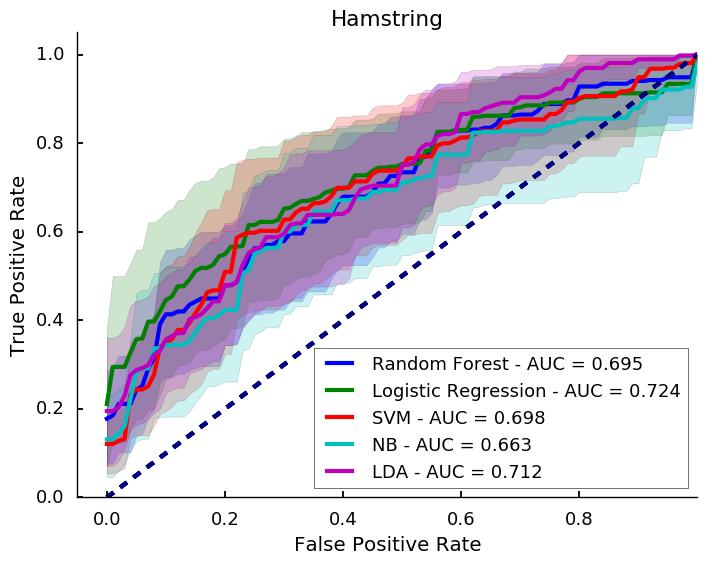

In [39]:
l = 'Hamstring'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]

Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
for clf,name in zip(models,model_name):
    print(name)
    results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),clf,0)

    AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=name,col=current_palette[c])
    AX.set_title(l)
    c+=1 #switch color

sns.despine()
plt.savefig('Hamstring.jpg',dpi=600)

## Use Stacking

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.603, worst base-clf Random Forest, minauc = 0.333
auc meta = 0.510

AUC = 0.5112, Sens = 0.9524, Spec = 0.1900

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf SVM, auc = 0.494, worst base-clf Random Forest, minauc = 0.358
auc meta = 0.406

AUC = 0.4058, Sens = 0.8679, Spec = 0.2000

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf NB, auc = 0.489, worst base-clf SVM, minauc = 0.271
auc meta = 0.425

AUC = 0.4257, Sens = 0.2857, Spec = 0.7400

Random Forest
Logistic Regression
SVM
NB
LDA
base-level classifiers trained
training meta-classifier
best base-clf LDA, auc = 0.896, worst base-clf Random Forest, minauc = 0.183
auc meta = 0.839

AUC = 0.8396, Sens = 0.7200, Spec = 0.8000

Random Forest
Logistic Regression
SVM
NB
LDA
base-l

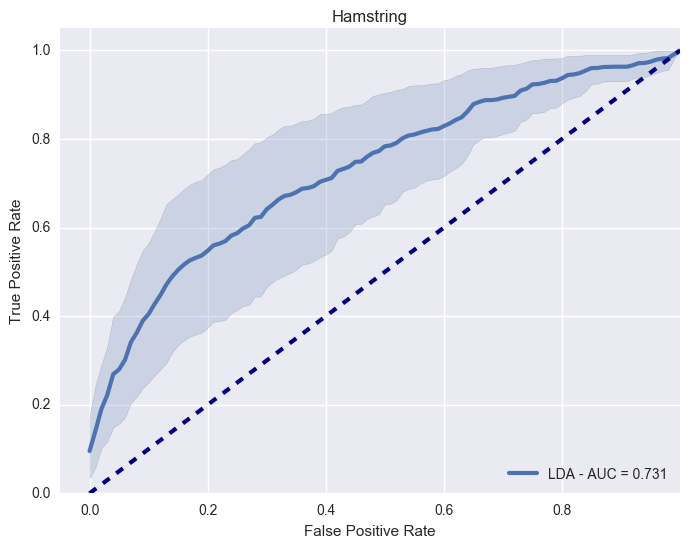

In [90]:
l = 'Hamstring'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]

Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),models,1)

AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=name,col=current_palette[c])
AX.set_title(l)


## Gastrocnemius

In [37]:
#Load Clips Data
# FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.8.csv')
# FullData = pd.read_csv(savepath+'Clips_ws0.5_overlap0.8.csv')
FullData = pd.read_csv(savepath+'Clips_ws1.0_overlap0.5.csv')

print (FullData.shape)

(1557, 20)


In [38]:
models = [RandomForestClassifier(n_estimators=200,random_state=2),
          LogisticRegression(C=.001),
          SVC(kernel='linear',C=.001,cache_size=1600,probability=True,random_state=3),
          GaussianNB(),
          LinearDiscriminantAnalysis()
         ]

Random Forest
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.8650, Sens = 1.0000, Spec = 0.8600

AUC = 0.6874, Sens = 0.6000, Spec = 0.8300

AUC = 0.1050, Sens = 1.0000, Spec = 0.0600

mean AUC = 0.664 (+/- 0.341)
mean Sens = 0.900 (+/- 0.173)
mean Spec = 0.688 (+/- 0.368)
Logistic Regression
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.0700, Sens = 1.0000, Spec = 0.0400



/Users/luca/anaconda/envs/py35/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


AUC = 0.9768, Sens = 0.8400, Spec = 1.0000

AUC = 0.1500, Sens = 1.0000, Spec = 0.0300

mean AUC = 0.549 (+/- 0.440)
mean Sens = 0.960 (+/- 0.069)
mean Spec = 0.518 (+/- 0.483)
SVM
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.3400, Sens = 1.0000, Spec = 0.2700

AUC = 0.9784, Sens = 0.8400, Spec = 1.0000

AUC = 0.2450, Sens = 1.0000, Spec = 0.1400

mean AUC = 0.641 (+/- 0.350)
mean Sens = 0.960 (+/- 0.069)
mean Spec = 0.603 (+/- 0.400)
NB
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.0500, Sens = 0.0000, Spec = 1.0000

AUC = 0.9086, Sens = 0.8000, Spec = 1.0000

AUC = 0.4450, Sens = 1.0000, Spec = 0.3600

mean AUC = 0.601 (+/- 0.381)
mean Sens = 0.700 (+/- 0.412)
mean Spec = 0.840 (+/- 0.277)
LDA
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.9100, Sens = 1.0000, Spec = 0.8600

AUC = 0.9284, Sens = 0.8400, Spec = 1.0000

AUC = 0.9150, Sens = 1.0000, Spec = 0.8600

mean AUC = 0.938 (+/- 0.036)
mean Sens = 0.960 (+/- 0.069)
mean Spec = 0.930 (+/- 0.070)


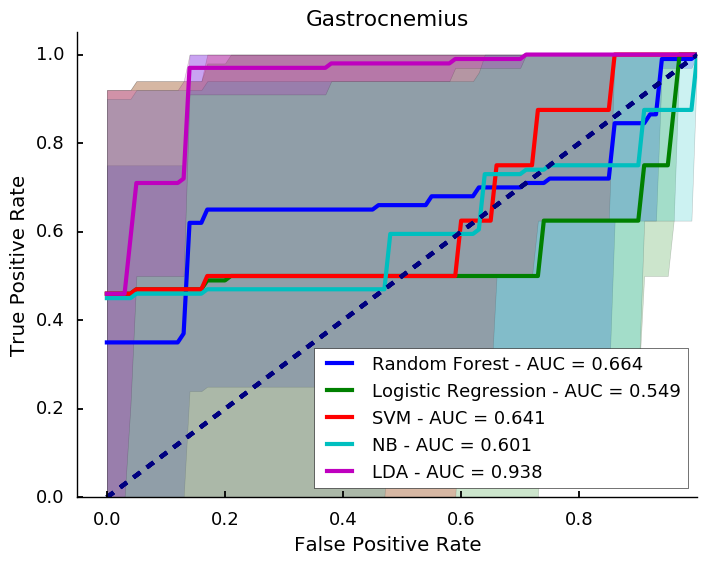

In [40]:
l = 'Gastrocnemius'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]

Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
for clf,name in zip(models,model_name):
    print(name)
    results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),clf,0)

    AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=name,col=current_palette[c])
    AX.set_title(l)
    c+=1 #switch color
    
sns.despine()
plt.savefig('Gastroc.jpg',dpi=600)

AUC = 1.0000, Sens = 1.0000, Spec = 1.0000

AUC = 0.9100, Sens = 1.0000, Spec = 0.8600

AUC = 0.9284, Sens = 0.8400, Spec = 1.0000

AUC = 0.9150, Sens = 1.0000, Spec = 0.8600

mean AUC = 0.938 (+/- 0.036)
mean Sens = 0.960 (+/- 0.069)
mean Spec = 0.930 (+/- 0.070)


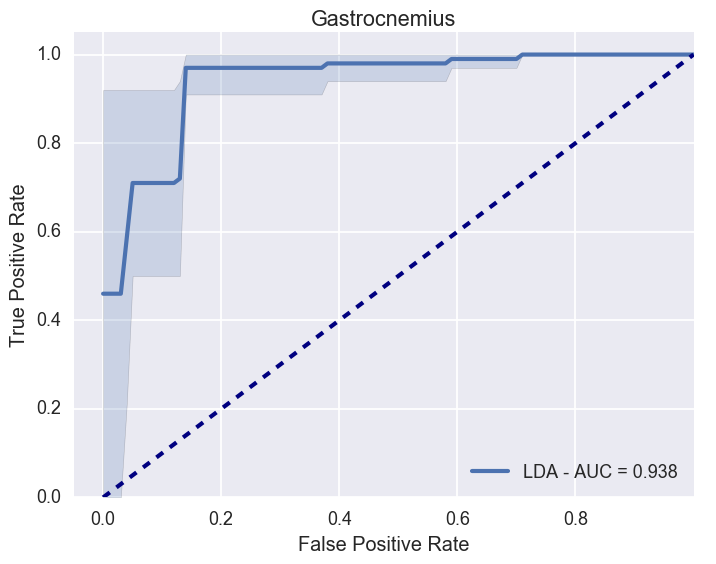

In [136]:
l = 'Gastrocnemius'
c = 0
Labels = FullData.Label
plt.figure(figsize=(8,6))

FiltData = FullData.loc[(Labels!='IA') & (FullData.Location==l)]
for s in FiltData.SubjID.unique():
    if len(FiltData[FiltData.SubjID==s].Label.unique())<2:
        FiltData = FiltData[FiltData.SubjID!=s]

Features = FiltData.iloc[:,0:14]
Features = Features.as_matrix()
SubjID = FiltData.SubjID
Label = FiltData.Label=='SA'
Location = FiltData.Location
        
#standardize data
scaler = preprocessing.StandardScaler().fit(Features) #define scaler on Healthy data
Features = scaler.transform(Features)
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)
        
results = LOSOCV(Features,Label.as_matrix(),FiltData,SubjID.as_matrix(),models[-1],0)

AX = plot_roc(results['TPR'],results['FPR'],np.mean(results['AUC']),ax=None,plotname=model_name[-1],col=current_palette[c])
AX.set_title(l)


In [142]:
results

{'AUC': [1.0, 0.91000000000000003, 0.9284, 0.91500000000000004],
 'FPR': array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,
         0.09,  0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,
         0.18,  0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,
         0.27,  0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,
         0.36,  0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,
         0.45,  0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,
         0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,
         0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,
         0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,
         0.81,  0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,
         0.9 ,  0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,
         0.99,  1.  ]),
 'Sens': [1.0, 1.0, 0.83999999999999997, 1.0],
 'Spec': [1.0, 0.85999999999999999, 1.0, 0.85999999999999999],
 'TPR': [arra

In [29]:
FiltData = pd.concat([pd.DataFrame(Features),
                      pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})],axis=1)

In [30]:
FiltData

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Label,Location,SubjID
0,10.281852,-0.047540,6.548987,4.988246,0.694025,1.466070,-0.829564,2.079150,3.589152,-2.831884,0.298303,4.827728,0.993655,1.501371,True,Gastrocnemius,1
1,4.098564,0.244480,0.824080,1.724432,1.100442,1.372337,0.322928,1.183330,1.782220,-2.476570,0.543958,1.613981,0.658532,1.238401,True,Gastrocnemius,1
2,4.261596,0.124163,0.812885,1.649533,1.403355,1.500909,0.453803,1.307462,1.822397,-2.528166,0.625843,1.669634,0.728841,1.369886,True,Gastrocnemius,1
3,4.906466,0.643078,0.602164,1.398007,1.505170,2.148697,2.292207,1.387761,1.995183,-2.624278,0.707728,1.921902,0.917468,1.632857,True,Gastrocnemius,1
4,4.708509,0.784601,0.930508,1.422989,3.506940,1.985700,1.444883,1.717158,2.298045,-2.747458,0.871499,2.391242,1.049668,1.764342,True,Gastrocnemius,1
5,5.084682,0.496656,0.206128,1.235235,3.017840,0.812137,-0.582209,1.327594,1.882637,-2.772164,0.871499,1.757003,0.837542,1.764342,True,Gastrocnemius,1
6,4.453954,0.256396,0.133891,0.902410,2.317555,0.829720,-0.259576,1.196381,1.684864,-2.779747,0.789614,1.480387,0.711590,1.632857,True,Gastrocnemius,1
7,4.316492,0.248869,0.188638,0.892958,2.324661,0.917845,-0.463637,1.184202,1.684167,-2.770330,0.789614,1.479293,0.743371,1.632857,True,Gastrocnemius,1
8,3.992381,1.234388,0.226473,1.204904,2.319366,1.120025,1.000205,1.248874,1.765668,-2.746335,0.707728,1.591454,0.836860,1.632857,True,Gastrocnemius,1
9,4.500279,1.110888,0.501287,0.864296,1.295929,1.231113,1.440026,1.032204,1.626936,-2.836115,0.462073,1.402410,0.421205,1.106916,True,Gastrocnemius,1


In [31]:
pd.DataFrame({'SubjID':SubjID.as_matrix(),'Label':Label.as_matrix(),'Location':Location.as_matrix()})

,Label,Location,SubjID
0,True,Gastrocnemius,1
1,True,Gastrocnemius,1
2,True,Gastrocnemius,1
3,True,Gastrocnemius,1
4,True,Gastrocnemius,1
5,True,Gastrocnemius,1
6,True,Gastrocnemius,1
7,True,Gastrocnemius,1
8,True,Gastrocnemius,1
9,True,Gastrocnemius,1


In [32]:
pd.DataFrame(Features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,10.281852,-0.047540,6.548987,4.988246,0.694025,1.466070,-0.829564,2.079150,3.589152,-2.831884,0.298303,4.827728,0.993655,1.501371
1,4.098564,0.244480,0.824080,1.724432,1.100442,1.372337,0.322928,1.183330,1.782220,-2.476570,0.543958,1.613981,0.658532,1.238401
2,4.261596,0.124163,0.812885,1.649533,1.403355,1.500909,0.453803,1.307462,1.822397,-2.528166,0.625843,1.669634,0.728841,1.369886
3,4.906466,0.643078,0.602164,1.398007,1.505170,2.148697,2.292207,1.387761,1.995183,-2.624278,0.707728,1.921902,0.917468,1.632857
4,4.708509,0.784601,0.930508,1.422989,3.506940,1.985700,1.444883,1.717158,2.298045,-2.747458,0.871499,2.391242,1.049668,1.764342
5,5.084682,0.496656,0.206128,1.235235,3.017840,0.812137,-0.582209,1.327594,1.882637,-2.772164,0.871499,1.757003,0.837542,1.764342
6,4.453954,0.256396,0.133891,0.902410,2.317555,0.829720,-0.259576,1.196381,1.684864,-2.779747,0.789614,1.480387,0.711590,1.632857
7,4.316492,0.248869,0.188638,0.892958,2.324661,0.917845,-0.463637,1.184202,1.684167,-2.770330,0.789614,1.479293,0.743371,1.632857
8,3.992381,1.234388,0.226473,1.204904,2.319366,1.120025,1.000205,1.248874,1.765668,-2.746335,0.707728,1.591454,0.836860,1.632857
9,4.500279,1.110888,0.501287,0.864296,1.295929,1.231113,1.440026,1.032204,1.626936,-2.836115,0.462073,1.402410,0.421205,1.106916
